# Data Wrangling - WeRateDogs Twitter Data

## Set up jupyter notebook

In [1]:
# Import all of the packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tweepy
import re
import requests
import json

%matplotlib inline 

## Gather

### Basic Tweet Data
This is the basic twitter data. I'm going to pull it into a pandas dataframe and have a quicklook at it so I get a general idea of how I can get everything together.

In [2]:
#grab the basic data from the given cs
basic_df = pd.read_csv('twitter-archive-enhanced.csv')
basic_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
#checking to make sure the tweet_id field is the correct data type for getting tweets via the api
basic_df.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [4]:
#checking the number of columns and rows of the data frame
basic_df.shape

(2356, 17)

### Image Predictions

Download the image prediction file and then read it in. Again preliminary viewing.

In [5]:
#Getting the predictiond tsv downloaded and saved locally (so I don't need to download again)
image_predictions = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(image_predictions)
with open('image_predictions.tsv', 'bw') as file:
    file.write(response.content)

In [6]:
#Reading the tsv into a pandas dataframe
pred_df = pd.read_csv('image_predictions.tsv', delimiter = '\t')
pred_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [7]:
#just checking the rows and columns (hmmm... alread something for the assess phase)
pred_df.shape

(2075, 12)

### Twitter JSON extraction
Here I am extracting the JSON data from the twitter API for each tweet. Then I save them into a text file. These will be two seperate cells, which will be run once (to avoid long download times).

After that the JSON files will be loaded. The retweet count and favorite count will be extracted and put in it's own dataframe to be joined with the other dataframes later.

#### Twitter API authentication
In order to avoid having my authentication information, I have put it into a text file. The file is called "tweet_keys.txt". I have included a text file as a template for the authentication. The file needs to have these lines:
1. API key
2. API secret key
3. Access token
4. Access token secret

In [8]:
#get the twitter keys to access the API
with open('tweet_keys.txt', 'r') as file:
    api_key = next(file)[:-1]
    api_secret = next(file)[:-1]
    access_token = next(file)[:-1]
    access_secret = next(file)[:-1]

#set up the authorization for tweepy
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [9]:
tweet_lists = []

#running through and creating a text file to hold each of the json data from the tweets
for hund_count in range(0, int(len(basic_df['tweet_id'])/100)):
    tweet_list = basic_df['tweet_id'][hund_count*100: (hund_count+1)*100].to_list()
    tweet_json = api.statuses_lookup(tweet_list, map = True)
    tweet_lists.append(tweet_json)

tweet_list = basic_df['tweet_id'][-(len(basic_df['tweet_id'])%100):].to_list()
tweet_json = api.statuses_lookup(tweet_list, map = True)
tweet_lists.append(tweet_json)

In [10]:
#running through and creating a text file to hold the json data from the tweets
with open('tweet_json.txt','w') as file:
    for tweet_list in tweet_lists:
        for tweet in tweet_list:
            json_str = json.dumps(tweet._json)
            json_json = json.loads(json_str)
            file.write(json_str + '\n')

In [11]:
#reading in the text file (created above) and extracting the rewteets and favorites counts. 
#if there's an error in the file, then these counts will become a numpy nan

#first set up lists to create dictionarys later in creating the dataframe
retweets = []
favorites = []
    
#second go through the text files and put the data into the lists
with open('tweet_json.txt', 'r') as file:
    for text in file:
        
        tweet_json = json.loads(text)
        if 'retweet_count' in tweet_json:
            retweets.append(tweet_json['retweet_count'])
        else:
            retweets.append(np.nan)
        if 'favorite_count' in tweet_json:
            favorites.append(tweet_json['favorite_count'])
        else:
            favorites.append(np.nan)

#put all of this in a dataframe: due to the nans, I'm having trouble 
json_df = pd.DataFrame({'tweet_id': basic_df['tweet_id'], 'retweets': retweets, 'favorites': favorites})
json_df.head()

,tweet_id,retweets,favorites
0,892420643555336193,2139.0,17504.0
1,892177421306343426,2851.0,19622.0
2,891815181378084864,72.0,0.0
3,891689557279858688,3124.0,20222.0
4,891327558926688256,7761.0,39096.0


### Merge Data
I am going to join all of these data sets into one dataframe. Arguably, the predictives could be in their own data frame, but one dataframe will make it more managable for the purposes of cleaning.

In [12]:
#Merge all the data into one dataframe, keeping only the data that corresponse to the basic data

#Technically, the first merge could have been an inner join, but if I hadn't created the json df, I'd want to remove
#the retweets and favorites that I didn't have other data
temp_df = pd.merge(basic_df, json_df, how = 'left', on = 'tweet_id')
dog_df = pd.merge(temp_df, pred_df, how = 'left', on = 'tweet_id')

dog_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


### Save the data
Well I've finished gathering my data. I'm going to save the dataframe here as a csv called dog data uncleaned.

In [13]:
#Saving a check point csv
dog_df.to_csv('dog_data_uncleaned.csv', index_label = False)

## Assess
At the end of this section I list the results of my assessment, which will become the plan for the cleaning section.

First load back up the dataframe.

In [14]:
dog_df = pd.read_csv('dog_data_uncleaned.csv')
dog_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [15]:
dog_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'retweets', 'favorites', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [16]:
dog_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweets,favorites,img_num,p1_conf,p2_conf,p3_conf
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000,2331.000000,2331.000000,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433,2667.494208,7482.023595,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237,4511.045558,11614.026261,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,1.000000,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000,541.000000,1301.000000,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000,1247.000000,3250.000000,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000,3101.000000,9164.000000,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000,76687.000000,154395.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


### Immediate numerical issues

Just looking at this, there are a few issues:

1) The tweet id should be a string not a number as they will not be computed with.

2) There are 78 tweets that are in reply to, I'll need to look at those I don't know if they should be included in this.

3) There are 181 retweets, which I will also need to look into.

4) The denomnators are mostly 10, with at least one 0 and one 170; from my understanding of these tweets, the denominator should be 10 (as the rating is out of 10). The 0s might be unrated tweets (need to look into that). The larger numbers are possible mistakes (again need to look into that more).

5) The numerators should be 10 or greater (possibly 8s or 9s)... yes, I know you can't have more then 10 out of 10, but dogs can't do math. The 0s look interesting; I'm wondering if they all correspond to the denominators of 0. Also, there's one that's 1776 is this relating to higher than 10 denominators.

6) There are only 877 retweets/favorites. That means there are a lot of tweets I couldn't get from the API... so many of these tweets have been removed or are not accessable by me. Or possibly, these weren't retweeted or favorited so didn't get this in the JSON file. I'll need to look into this more. EDIT: I was using get_status which seemed to stop after looking up a certain number of tweets. I redid this using statuses_lookup and now I'm only missing 10 which I assume have been taken down from twitter for some reason.

7) There are 2075 dog images in the predictions. I need to look into this, but it might be that there aren't any images related to this.

8) These columns should be ints instead of floats: numerator, denominator, retweets, favorites, and img_number.

In [17]:
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [18]:
dog_df.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
retweets                      1672
favorites                     1986
jpg_url                       2009
img_num                          4
p1                             378
p1_conf                       2006
p1_dog                           2
p2                             405
p2_conf                       2004
p2_dog                           2
p3                             408
p3_conf             

### Unique value queries
A few thoughts on this output:

1) What is sourse and why are there only 4? I will look into that more.

2) There are only two values for 'doggo', 'floofer', 'pupper', and 'puppo'. These might be able to be put in one column.

3) px_dog appears to be a true or false if it's a dog or not; so why are there falses here. Might be that the the picture was too complicated for the machine learning to pick out the dog (there are values like banana and spatula).

### Silly word exploration

I'm going to look more closely if I can colapse the 'doggo', 'floofer', 'pupper', and 'puppo' columns

In [19]:
print(dog_df['doggo'].value_counts())
print(dog_df['floofer'].value_counts())
print(dog_df['pupper'].value_counts())
print(dog_df['puppo'].value_counts())

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


In [20]:
dog_df[dog_df['doggo']=='doggo'][['doggo','floofer', 'pupper', 'puppo']].nunique()

doggo      1
floofer    2
pupper     2
puppo      2
dtype: int64

In [21]:
dog_df[dog_df['floofer']=='floofer'][['doggo','floofer', 'pupper', 'puppo']].nunique()

doggo      2
floofer    1
pupper     1
puppo      1
dtype: int64

In [22]:
dog_df[dog_df['pupper']=='pupper'][['doggo','floofer', 'pupper', 'puppo']].nunique()

doggo      2
floofer    1
pupper     1
puppo      1
dtype: int64

In [23]:
dog_df[dog_df['puppo']=='puppo'][['doggo','floofer', 'pupper', 'puppo']].nunique()

doggo      2
floofer    1
pupper     1
puppo      1
dtype: int64

A doggo can be a floofer, pupper, or puppo. Floofer, pupper, and puppo don't overlap. Let's look closer at the overlaps.

In [24]:
print(dog_df[dog_df['floofer']=='floofer']['doggo'].value_counts())
print(dog_df[dog_df['pupper']=='pupper']['doggo'].value_counts())
print(dog_df[dog_df['puppo']=='puppo']['doggo'].value_counts())

None     9
doggo    1
Name: doggo, dtype: int64
None     245
doggo     12
Name: doggo, dtype: int64
None     29
doggo     1
Name: doggo, dtype: int64


A strange thing, these words are the signature of this account, why are there so few... around 10% of the tweets. It could be because of things like capilolization. I'll need to run a check it theres an issue with this. 

There are also other terms in the dogtionary that are not included (blep and snoot) and floofer is floof in the dogtionary. If I'm doing a text search I might as we get these other terms and change floofer to floof.

I'm going to add a dogtionary column with a list of all the terms in the tweet. If there are no terms, I will make it nan so it easier to sort which have terms and which don't.

### Retweet/Favorites missing
I'm going to look at a few of the json files to see what's going on with the missing retweets/favorites. It would be odd if all of these were missing from Twitter.

In [25]:
#checking the 25 missing nans in retweets
retweet_nan = dog_df[dog_df['retweets'].isnull()]
retweet_nan

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
13,889638837579907072,NaN,NaN,2017-07-25 00:10:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ted. He does his best. Sometimes that'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889638837...,...,1.0,French_bulldog,0.991650,True,boxer,0.002129,True,Staffordshire_bullterrier,0.001498,True
44,883838122936631299,NaN,NaN,2017-07-09 00:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Noah. He can't believe someone made th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883838122...,...,1.0,Doberman,0.610946,True,miniature_pinscher,0.299603,True,kelpie,0.063020,True
110,871102520638267392,NaN,NaN,2017-06-03 20:33:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,NaN,NaN,NaN,https://twitter.com/animalcog/status/871075758...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,869596645499047938,NaN,NaN,2017-05-30 16:49:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. He just graduated. Officially a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/869596645...,...,1.0,Chihuahua,0.955156,True,toy_terrier,0.008054,True,muzzle,0.006296,False
124,868639477480148993,NaN,NaN,2017-05-28 01:26:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to Cooper. His expres...,8.685523e+17,4.196984e+09,2017-05-27 19:39:34 +0000,"https://www.gofundme.com/3ti3nps,https://twitt...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,864873206498414592,NaN,NaN,2017-05-17 16:00:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please don't send in Jesus....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/864873206...,...,2.0,pole,0.478616,False,lakeside,0.114182,False,wreck,0.055926,False
181,857029823797047296,NaN,NaN,2017-04-26 00:33:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zeke. He performs group cheeky wink tu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/857029823...,...,2.0,golden_retriever,0.968623,True,Labrador_retriever,0.010325,True,Saluki,0.004148,True
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,...,2.0,Blenheim_spaniel,0.389513,True,Pekinese,0.188220,True,Japanese_spaniel,0.082628,True
201,853760880890318849,NaN,NaN,2017-04-17 00:03:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Alice. I'm told she enjoys car ri...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/853760880...,...,1.0,miniature_pinscher,0.292519,True,Chihuahua,0.120946,True,Rottweiler,0.119490,True
232,847962785489326080,NaN,NaN,2017-04-01 00:04:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Georgie. He's very shy. Only puppears ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/847962785...,...,1.0,sea_lion,0.882654,False,mink,0.066880,False,otter,0.025679,False


I went through and found that at least some of these are indeed on twitter (tried 4 and they were all there). I'm not sure why they are not showing up in the big batch grab. In another notebook, I tried getting them individually and I was able to pull them. I will pull them individually in the cleaning phase.

### Denominator issues
I'm going to look at denominators that are not 10.

In [26]:
dog_df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

There are only 23 values that are not 10. It might be that they were pulled wrong. I'm going to look at the text for some of these and see if the value is correct.

In [27]:
#grab the ids of the the 23 and then check the text
den_issues = dog_df[dog_df['rating_denominator'] != 10]
den_issues['text']

313     @jonnysun @Lin_Manuel ok jomny I know you're e...
342              @docmisterio account started on 11/15/15
433     The floofs have been released I repeat the flo...
516     Meet Sam. She smiles 24/7 &amp; secretly aspir...
784     RT @dog_rates: After so many requests, this is...
902     Why does this never happen at my front door......
1068    After so many requests, this is Bretagne. She ...
1120    Say hello to this unbelievably well behaved sq...
1165    Happy 4/20 from the squad! 13/10 for all https...
1202    This is Bluebert. He just saw that both #Final...
1228    Happy Saturday here's 9 puppers on a bench. 99...
1254    Here's a brigade of puppers. All look very pre...
1274    From left to right:\nCletus, Jerome, Alejandro...
1351    Here is a whole flock of puppers.  60/50 I'll ...
1433    Happy Wednesday here's a bucket of pups. 44/40...
1598    Yes I do realize a rating of 4/20 would've bee...
1634    Two sneaky puppers were not initially seen, mo...
1635    Someon

Looking at the text it appears that there might have been an issue when there were more then 1 slash. I'm going to look at the numerators as well and see if these are the same issue.

In [28]:
dog_df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [29]:
den_issues['rating_numerator'].value_counts()

4      2
9      2
60     1
45     1
1      1
99     1
165    1
7      1
11     1
204    1
88     1
121    1
143    1
80     1
44     1
50     1
84     1
144    1
20     1
24     1
960    1
Name: rating_numerator, dtype: int64

This might not catch all the numerator issues. What I can do is take the text, split it on the / and look for the 10s. The denominaotor would be the 10 and the numerator would be the number directly infront of that. That should clean things up a bit

### Source
I'm going to look at the 4 sources and see if there's anything useful interesting there.

In [30]:
dog_df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

Okay, that makes sense, the source is how the tweet was posted. As it is right now this is unweildly, so it should be boiled down to the actual source instead of the reference.

### No image
The directions say that we should only have tweets with images. So anything that is nan in the jpg_url will probably need to go. I am going to get the ids and check a sample of them on twitter. I have a feeling that these are videos and so could not be parsed by the machine learning algorithm.

In [31]:
no_image = dog_df[dog_df['jpg_url'].isnull()]
no_image.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
386,826615380357632002,NaN,NaN,2017-02-01 02:17:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Please only send in dogs. We on...,8.099208e+17,4.196984e+09,2016-12-17 00:38:52 +0000,https://twitter.com/dog_rates/status/809920764...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,834477809192075265,NaN,NaN,2017-02-22 18:59:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Leo. He was a skater pu...,8.295020e+17,4.196984e+09,2017-02-09 01:27:41 +0000,https://twitter.com/dog_rates/status/829501995...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,875097192612077568,NaN,NaN,2017-06-14 21:06:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You'll get your package when that precious man...,NaN,NaN,NaN,https://twitter.com/drboondoc/status/874413398...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
764,777953400541634568,NaN,NaN,2016-09-19 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Gerald. He's a fairly exot...,7.681934e+17,4.196984e+09,2016-08-23 21:09:14 +0000,https://twitter.com/dog_rates/status/768193404...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,790227638568808452,NaN,NaN,2016-10-23 16:25:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Leela. She's a Fetty Wo...,7.626999e+17,4.196984e+09,2016-08-08 17:19:51 +0000,https://twitter.com/dog_rates/status/762699858...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,846139713627017216,NaN,NaN,2017-03-26 23:20:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",SHE DID AN ICY ZOOM AND KNEW WHEN TO PUT ON TH...,NaN,NaN,NaN,https://twitter.com/csncapitals/status/8460884...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,814578408554463233,NaN,NaN,2016-12-29 21:06:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur ...,6.981954e+17,4.196984e+09,2016-02-12 17:22:12 +0000,https://twitter.com/dog_rates/status/698195409...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397,825120256414846976,NaN,NaN,2017-01-27 23:16:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to Pablo. He's one go...,8.250266e+17,4.196984e+09,2017-01-27 17:04:02 +0000,https://www.gofundme.com/my-puppys-double-cata...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
655,791784077045166082,NaN,NaN,2016-10-27 23:30:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: I'm not sure what this dog is d...,6.820881e+17,4.196984e+09,2015-12-30 06:37:25 +0000,"https://vine.co/v/iqMjlxULzbn,https://vine.co/...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,863427515083354112,8.634256e+17,77596200.0,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some of these do have jpgs. I can go through the json files of the items with no images listed and extract the first jpeg from the files. The rest will be deleted.

### Retweets
The retweets should be removed as they won't have original ratings. I am going to look at a few though just to make sure.

In [32]:
no_image = dog_df[dog_df['retweeted_status_id'].notnull()]
no_image.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
594,798705661114773508,NaN,NaN,2016-11-16 01:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Baloo. He's expecting a fa...,7.406770e+17,4.196984e+09,2016-06-08 22:48:46 +0000,https://twitter.com/dog_rates/status/740676976...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
829,768909767477751808,NaN,NaN,2016-08-25 20:35:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: When it's Janet from accounting...,7.001438e+17,4.196984e+09,2016-02-18 02:24:13 +0000,https://twitter.com/dog_rates/status/700143752...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
692,787111942498508800,NaN,NaN,2016-10-15 02:04:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Carl. He's very powerfu...,7.529324e+17,4.196984e+09,2016-07-12 18:27:35 +0000,"https://vine.co/v/OEppMFbejFz,https://vine.co/...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
767,777641927919427584,NaN,NaN,2016-09-18 22:54:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Arnie. He's a Nova Scot...,7.504293e+17,4.196984e+09,2016-07-05 20:41:01 +0000,https://twitter.com/dog_rates/status/750429297...,...,1.0,golden_retriever,0.964929,True,Labrador_retriever,0.011584,True,refrigerator,0.007499,False
601,798665375516884993,NaN,NaN,2016-11-15 23:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lola. She fell asleep o...,6.718968e+17,4.196984e+09,2015-12-02 03:40:57 +0000,https://twitter.com/dog_rates/status/671896809...,...,1.0,chow,0.243529,True,hamster,0.227150,False,Pomeranian,0.056057,True
618,796177847564038144,NaN,NaN,2016-11-09 02:29:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Ruby. She just turned o...,7.961497e+17,4.196984e+09,2016-11-09 00:37:46 +0000,https://twitter.com/dog_rates/status/796149749...,...,1.0,golden_retriever,0.600276,True,Labrador_retriever,0.140798,True,seat_belt,0.087355,False
720,783347506784731136,NaN,NaN,2016-10-04 16:46:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Kenny. He just wants to...,6.742918e+17,4.196984e+09,2015-12-08 18:17:56 +0000,https://twitter.com/dog_rates/status/674291837...,...,1.0,Cardigan,0.611525,True,Pembroke,0.368566,True,Chihuahua,0.003330,True
250,845098359547420673,NaN,NaN,2017-03-24 02:22:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bungalo. She uses that ...,7.733088e+17,4.196984e+09,2016-09-06 23:56:05 +0000,https://twitter.com/dog_rates/status/773308824...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,860981674716409858,NaN,NaN,2017-05-06 22:16:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Lorenzo. He's an avid nift...,8.605638e+17,4.196984e+09,2017-05-05 18:36:06 +0000,https://www.gofundme.com/help-lorenzo-beat-can...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As I thought, these should be deleted and then the retweet columns should also be deleted.

### reply to
Just like the retweets, I need to make sure these are really ratings from the We Rate Dogs people.

In [33]:
no_image = dog_df[dog_df['in_reply_to_status_id'].notnull()]
no_image.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1598,686035780142297088,6.860340e+17,4.196984e+09,2016-01-10 04:04:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Yes I do realize a rating of 4/20 would've bee...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427,821153421864615936,8.211526e+17,1.132119e+08,2017-01-17 00:33:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@imgur for a polar bear tho I'd say 13/10 is a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
409,823333489516937216,8.233264e+17,1.582854e+09,2017-01-23 00:56:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@HistoryInPics 13/10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1634,684225744407494656,6.842229e+17,4.196984e+09,2016-01-05 04:11:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Two sneaky puppers were not initially seen, mo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684225744...,...,2.0,golden_retriever,0.203249,True,Samoyed,0.067958,True,Great_Pyrenees,0.065327,True
1940,673716320723169284,6.737159e+17,4.196984e+09,2015-12-07 04:11:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The millennials have spoken and we've decided ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1819,676590572941893632,6.765883e+17,4.196984e+09,2015-12-15 02:32:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After some outrage from the crowd. Bubbles is ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,847617282490613760,8.476062e+17,4.196984e+09,2017-03-31 01:11:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",.@breaannanicolee PUPDATE: Cannon has a heart ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1895,674742531037511680,6.747400e+17,4.196984e+09,2015-12-10 00:08:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Some clarification is required. The dog is sin...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most of these are comments on previous posts made by We Rate Dogs or rating dogs that other people shared (sometimes with their own ratings). I'm going to remove them as they are not original thoughts. If I was doing this projects for someone else, I would be asking their opinion at this point.

### Quality
- Change tweet ID to strings.
- change retweets, favorates, image number, numerator, and denominator to integers
- pull (or at least try) the missing retweet and favorite data.
- check for multiple /s and then find the correct rating in the text to fix numerator and denominator ratings.
- run a check on the texts to see if there are more doggos, floofers, puppers, and puppos that have capitols.
- get a jpeg from the json file for all items without jpegs if possible. If it's not possible, delete these entries
- delete retweets and their corresponding columns.
- delete reply to and their corresponding columns.
- change the sources to just iPhone, Vine, Web, and TweetDeck.
- Change floofer to floof, add snoot and blep, then search through all of the text for the dogtionary terms.

### Tidiness
- Create a column containing a list of all dogtionary terms then delete the dogtionary terms.
- get most likely dog and it's probability then delete the probability columns.

## Clean
First make a copy of the data set. As I can get forgetful I'm going to make a copy called not cleaned so I can still use the dog df as normal.

In [34]:
dog_df_not_cleaned = dog_df.copy()

1) delete the retweets and reply tos along with those columns.

In [35]:
dog_df = dog_df[dog_df['retweeted_status_id'].isnull()]
dog_df.shape

(2175, 30)

In [36]:
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [37]:
dog_df = dog_df[dog_df['in_reply_to_status_id'].isnull()]
dog_df.shape

(2097, 30)

In [38]:
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

In [39]:
dog_df = dog_df.drop(columns = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id',
       'retweeted_status_timestamp'])
dog_df.shape

(2097, 25)

2) Look for missing retweets and favorites and delete the rows that don't have the json data.

In [40]:
missing_retweets = dog_df[dog_df['retweets'].isnull()]['tweet_id']

for tweet_id in missing_retweets:
    try:
        tweet = api.get_status(tweet_id)
        tweet_dump = json.dumps(tweet._json)
        tweet_json = json.loads(tweet_dump)
        dog_df.loc[dog_df['tweet_id'] == tweet_id, 'retweets'] = tweet_json['retweet_count']
        dog_df.loc[dog_df['tweet_id'] == tweet_id, 'favorites'] = tweet_json['favorite_count']
    except:
        print(str(tweet_id) + " doesn't exist")
        
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2097 non-null   int64  
 1   timestamp           2097 non-null   object 
 2   source              2097 non-null   object 
 3   text                2097 non-null   object 
 4   expanded_urls       2094 non-null   object 
 5   rating_numerator    2097 non-null   int64  
 6   rating_denominator  2097 non-null   int64  
 7   name                2097 non-null   object 
 8   doggo               2097 non-null   object 
 9   floofer             2097 non-null   object 
 10  pupper              2097 non-null   object 
 11  puppo               2097 non-null   object 
 12  retweets            2097 non-null   float64
 13  favorites           2097 non-null   float64
 14  jpg_url             1971 non-null   object 
 15  img_num             1971 non-null   float64
 16  p1    

List the missing retweets to check them out and if they don't remove them. In previous iterations I couldn't grab some of these. I'm keeping this in as a legacy.

In [41]:
dog_df[dog_df['retweets'].isnull()]['tweet_id']

Series([], Name: tweet_id, dtype: int64)

If there were any missing tweets, the rows would be deleted.

In [42]:
dog_df = dog_df[dog_df['retweets'].notnull()]
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2097 non-null   int64  
 1   timestamp           2097 non-null   object 
 2   source              2097 non-null   object 
 3   text                2097 non-null   object 
 4   expanded_urls       2094 non-null   object 
 5   rating_numerator    2097 non-null   int64  
 6   rating_denominator  2097 non-null   int64  
 7   name                2097 non-null   object 
 8   doggo               2097 non-null   object 
 9   floofer             2097 non-null   object 
 10  pupper              2097 non-null   object 
 11  puppo               2097 non-null   object 
 12  retweets            2097 non-null   float64
 13  favorites           2097 non-null   float64
 14  jpg_url             1971 non-null   object 
 15  img_num             1971 non-null   float64
 16  p1    

3) Looking for any missing images. Deleting any rows that don't have a jpg attached to the tweet.

In [43]:
missing_images = dog_df[dog_df['jpg_url'].isnull()]['tweet_id']
no_jpg_list = []

with open('tweet_json.txt', 'r') as file:
    for text in file:
        tweet_json = json.loads(text)
        #print(str(tweet_json['id'] in missing_images))
        if tweet_json['id'] in missing_images.values:

            #I looked into this in another notebook so know where to look
            try:
                tweet_media = tweet_json['entities']['media'][0]['media_url']
                if tweet_media[:-3] == 'jpg':
                    dog_df.loc[dog_df['tweet_id'] == tweet, 'jpg_url'] = tweet_media
                    dog_df.loc[dog_df['tweet_id'] == tweet, 'img_num'] = 1
                else:
                    no_jpg_list.append(tweet_json['id'])
            except:
                no_jpg_list.append(tweet_json['id'])
            
len(no_jpg_list)


126

Now running a visual check to make sure these definitly don't have jpgs.

In [44]:
no_jpg_df = pd.DataFrame(index=[no_jpg_list])
no_jpg_df.sample(5)

""
742534281772302336
676121918416756736
784183165795655680
706153300320784384
838952994649550848


From this sample it looks like there are three categories: videos, links, and quotes. The first two, I can't get jpegs from. The quotes can have jpegs, but as they are originally posted by someone else and they don't have predictions, so I'll drop them.

In [45]:
dog_df = dog_df[dog_df['jpg_url'].notnull()]
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   int64  
 1   timestamp           1971 non-null   object 
 2   source              1971 non-null   object 
 3   text                1971 non-null   object 
 4   expanded_urls       1971 non-null   object 
 5   rating_numerator    1971 non-null   int64  
 6   rating_denominator  1971 non-null   int64  
 7   name                1971 non-null   object 
 8   doggo               1971 non-null   object 
 9   floofer             1971 non-null   object 
 10  pupper              1971 non-null   object 
 11  puppo               1971 non-null   object 
 12  retweets            1971 non-null   float64
 13  favorites           1971 non-null   float64
 14  jpg_url             1971 non-null   object 
 15  img_num             1971 non-null   float64
 16  p1    

4) Fix data types

In [46]:
dog_df[['tweet_id']] = dog_df[['tweet_id']].astype('str', copy = False)
dog_df[['rating_numerator', 'rating_denominator', 'retweets', 'favorites', 'img_num']] = dog_df[['rating_numerator', 
        'rating_denominator', 'retweets', 'favorites', 'img_num']].astype('int32', copy = False)
dog_df.dtypes

tweet_id               object
timestamp              object
source                 object
text                   object
expanded_urls          object
rating_numerator        int32
rating_denominator      int32
name                   object
doggo                  object
floofer                object
pupper                 object
puppo                  object
retweets                int32
favorites               int32
jpg_url                object
img_num                 int32
p1                     object
p1_conf               float64
p1_dog                 object
p2                     object
p2_conf               float64
p2_dog                 object
p3                     object
p3_conf               float64
p3_dog                 object
dtype: object

5) Get the source column to something easier to use.

In [47]:
#creating a source dictionary, while I'm sure I could figure this out programatically, I just copied and pasted the 4 values.
source_dict = {'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>':'iPhone', 
               '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>':'Vine', 
               '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>':'Website',
               '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>':'TweetDeck'}

dog_df['source'] = dog_df['source'].apply(lambda x: source_dict[x])
dog_df['source'].value_counts()

iPhone       1932
Website        28
TweetDeck      11
Name: source, dtype: int64

Apparently all of the vine sources has some type of issue and was removed.

6) Check the denominators and numerators by spliting the text on the /s

Note: I ran this previously and found 40 issues, after looking at these, I revised the algorithim to address these.

In [48]:
issue_items = []

# found 1 decimal numerator, I'm going to have to change the column back to floats :(

dog_df[['rating_numerator']] = dog_df[['rating_numerator']].astype('float32', copy = False)

# I have been told that this can be done easier with regular expressions. I don't have enough experiance with these,
# but I will look into them for the future as it looks like it will make coding much simpler.
for tweet in dog_df['tweet_id']:
    splits = dog_df[dog_df['tweet_id'] == tweet].iloc[0]['text'].split('/')
    
    numerator = 0.0
    denominator = 0
    # look for the first few characters are multiples of 10 of each split. Skip the first split because that can't be the 
    # denominator. After trying this previously, it turns out they add up the numerator and denominators if there are multiple 
    # dogs because dogs can't do math. I'm going to find all appropriate denominator multiples of 10 and add the numerators
    # and denominators together. Anything I can't get here I'll look at visually.
    for i in range(1,len(splits)):
        denom_check = ''
        j = 0
        while j < len(splits[i]) and splits[i][j].isdigit():
            denom_check += splits[i][j]
            j += 1
        #only using denominators that are multiples of 10, now checking the numerators
        if denom_check != '' and denom_check[-1] == '0':
            numer_check = ''
            j = -1
            while ((-1)*j) < (len(splits[i-1])) and (splits[i-1][j].isdigit() or splits[i-1][j] == '.'):
                numer_check = splits[i-1][j] + numer_check
                j -= 1
            #checking for periods at the front for instance elipcies
            while numer_check != '' and (not numer_check[0].isdigit()):
                if len(numer_check) > 1:
                    numer_check = numer_check[1:]
                else:
                    numer_check = ''
            if numer_check != '':
                numerator += float(numer_check)
                denominator += int(denom_check)
    
    
    if numerator == 0.0:
        issue_items.append(tweet)
    else:
        dog_df.loc[dog_df['tweet_id'] == tweet, 'rating_numerator'] = numerator
        dog_df.loc[dog_df['tweet_id'] == tweet, 'rating_denominator'] = denominator

len(issue_items)

3

there are 3 issues, time for a visual check on those.

In [49]:
for tweet in issue_items:
    print(tweet)
    print(dog_df.loc[dog_df['tweet_id'] == tweet].iloc[0]['text'])

835152434251116546
When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
810984652412424192
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
676957860086095872
10/10 I'd follow this dog into battle no questions asked https://t.co/ngTNXYQF0L


Two tweets were not caught by the alogrithm. While I wish I could figure it out, with only 2, I'm just going to manually enter them. The other tweet does not have a rating, so I'm going to delete it.

In [50]:
dog_df.loc[dog_df['tweet_id'] == '835152434251116546', 'rating_numerator'] = 0
dog_df.loc[dog_df['tweet_id'] == '835152434251116546', 'rating_denominator'] = 10

dog_df.loc[dog_df['tweet_id'] == '676957860086095872', 'rating_numerator'] = 10
dog_df.loc[dog_df['tweet_id'] == '676957860086095872', 'rating_denominator'] = 10

dog_df = dog_df.drop(index = dog_df.loc[dog_df['tweet_id'] == '810984652412424192'].index[0])
dog_df.shape

(1970, 25)

Now, let's take a look at these columns.

In [51]:
dog_df[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,1970.000000,1970.000000
mean,12.258264,10.609137
std,41.626137,6.977765
min,0.000000,10.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [52]:
dog_df['rating_denominator'].value_counts()

10     1935
20       21
80        2
50        2
30        2
170       1
150       1
120       1
110       1
90        1
70        1
60        1
40        1
Name: rating_denominator, dtype: int64

In [53]:
dog_df['rating_numerator'].value_counts()

12.00      441
10.00      407
11.00      390
13.00      254
9.00       150
8.00        93
7.00        50
14.00       36
6.00        32
5.00        30
3.00        19
4.00        14
2.00        13
17.00        5
1.00         4
19.00        4
15.00        3
21.00        2
9.75         1
0.00         1
23.00        1
13.50        1
84.00        1
11.27        1
204.00       1
88.00        1
121.00       1
99.00        1
1776.00      1
11.26        1
165.00       1
20.00        1
144.00       1
61.00        1
16.00        1
44.00        1
60.00        1
45.00        1
80.00        1
420.00       1
18.00        1
Name: rating_numerator, dtype: int64

7) Dogtionary columns.

First, change floof not floofer. Then, I'm going to add blep and snoot columns. After that, go through the text and find the terms that were missed by searching it as lower case. Then create a dogtionary_term column and populating it with an empty list. Then go through and append the terms to the list. Finally, turn all of the empty lists to nan.

In [54]:
dog_df.rename(columns = {'floofer':'floof'}, inplace = True)
dogtionary_columns = ['doggo', 'floof', 'pupper', 'puppo', 'blep', 'snoot']
dog_df['blep'] = 'None'
dog_df['snoot'] = 'None'

dog_df[dogtionary_columns].head()

,doggo,floof,pupper,puppo,blep,snoot
0,None,None,None,None,None,None
1,None,None,None,None,None,None
2,None,None,None,None,None,None
3,None,None,None,None,None,None
4,None,None,None,None,None,None


In [55]:
# now to go through the text and find any of uses of the terms
for tweet in dog_df['tweet_id']:
    text = dog_df[dog_df['tweet_id'] == tweet].iloc[0]['text']
    for term in dogtionary_columns:
        if text.lower().find(term) > -1:
            dog_df.loc[dog_df['tweet_id'] == tweet, term] = term

for term in dogtionary_columns:
    print(dog_df[term].value_counts())

None     1891
doggo      79
Name: doggo, dtype: int64
None     1933
floof      37
Name: floof, dtype: int64
None      1737
pupper     233
Name: pupper, dtype: int64
None     1941
puppo      29
Name: puppo, dtype: int64
None    1966
blep       4
Name: blep, dtype: int64
None    1970
Name: snoot, dtype: int64


In [56]:
dog_df['dogtionary_terms'] = np.nan
dog_df['dogtionary_terms'] = dog_df['dogtionary_terms'].astype('object')
dog_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floof,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,blep,snoot,dogtionary_terms
0,892420643555336193,2017-08-01 16:23:56 +0000,iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,None,...,False,bagel,0.085851,False,banana,0.076110,False,None,None,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,None,...,True,Pekinese,0.090647,True,papillon,0.068957,True,None,None,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,None,...,True,malamute,0.078253,True,kelpie,0.031379,True,None,None,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,None,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None,None,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,None,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None,None,NaN


In [57]:
for tweet in dog_df['tweet_id']:
    all_terms = []
    for term in dogtionary_columns:
        if dog_df.loc[dog_df['tweet_id'] == tweet, term].iloc[0] == term:
            all_terms.append(term)
    if len(all_terms) > 0:
        dog_df.at[dog_df.loc[dog_df['tweet_id'] == tweet].index[0], 'dogtionary_terms'] = all_terms
            
dog_df['dogtionary_terms'].value_counts()

[pupper]           223
[doggo]             67
[floof]             34
[puppo]             27
[doggo, pupper]      8
[blep]               3
[doggo, floof]       2
[doggo, puppo]       2
[floof, pupper]      1
[pupper, blep]       1
Name: dogtionary_terms, dtype: int64

In [58]:
dog_df.drop(columns = dogtionary_columns)
dog_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floof',
       'pupper', 'puppo', 'retweets', 'favorites', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'blep', 'snoot', 'dogtionary_terms'],
      dtype='object')

8) Most likely dog
Instead of having all of the preditions, I'm just going to include the most likely dog along with the probability.

Note: One of the first images I saw when I was looking at "We Rate Dogs" was a picture of a dog through a bagel or doughnut. This was probably not picked up by the machine learning algorithm. As such, I'm going to leave them, but put "no dog predicted" in the most likely column.

In [59]:
#first make the new columns
dog_df['most_likely_dog'] = 'no dog predicted'
dog_df['prob'] = 0.0

#now grab the most likely dog from the predictions.
for tweet in dog_df['tweet_id']:
    if dog_df[dog_df['tweet_id'] == tweet].iloc[0]['p1_dog']:
        dog_df.loc[dog_df['tweet_id'] == tweet, 'most_likely_dog'] = dog_df[dog_df['tweet_id'] == tweet].iloc[0]['p1']
        dog_df.loc[dog_df['tweet_id'] == tweet, 'prob'] = dog_df[dog_df['tweet_id'] == tweet].iloc[0]['p1_conf']
    else:
        if dog_df[dog_df['tweet_id'] == tweet].iloc[0]['p2_dog']:
            dog_df.loc[dog_df['tweet_id'] == tweet, 'most_likely_dog'] = dog_df[dog_df['tweet_id'] == tweet].iloc[0]['p2']
            dog_df.loc[dog_df['tweet_id'] == tweet, 'prob'] = dog_df[dog_df['tweet_id'] == tweet].iloc[0]['p2_conf']
        else:
            if dog_df[dog_df['tweet_id'] == tweet].iloc[0]['p3_dog']:
                dog_df.loc[dog_df['tweet_id'] == tweet, 'most_likely_dog'] = dog_df[dog_df['tweet_id'] == tweet].iloc[0]['p3']
                dog_df.loc[dog_df['tweet_id'] == tweet, 'prob'] = dog_df[dog_df['tweet_id'] == tweet].iloc[0]['p3_conf']
                
dog_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floof,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,blep,snoot,dogtionary_terms,most_likely_dog,prob
0,892420643555336193,2017-08-01 16:23:56 +0000,iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,None,...,0.085851,False,banana,0.076110,False,None,None,NaN,no dog predicted,0.000000
1,892177421306343426,2017-08-01 00:17:27 +0000,iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,None,...,0.090647,True,papillon,0.068957,True,None,None,NaN,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03 +0000,iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,None,...,0.078253,True,kelpie,0.031379,True,None,None,NaN,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51 +0000,iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,None,...,0.168086,True,spatula,0.040836,False,None,None,NaN,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24 +0000,iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,None,...,0.225770,True,German_short-haired_pointer,0.175219,True,None,None,NaN,basset,0.555712


In [60]:
dog_df = dog_df.drop(columns = ['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'])
dog_df.shape

(1970, 21)

In [61]:
dog_df['most_likely_dog'].value_counts().head(20)

no dog predicted            305
golden_retriever            155
Labrador_retriever          106
Pembroke                     94
Chihuahua                    90
pug                          62
toy_poodle                   50
chow                         48
Samoyed                      42
Pomeranian                   41
malamute                     33
French_bulldog               31
Chesapeake_Bay_retriever     31
cocker_spaniel               30
miniature_pinscher           24
Eskimo_dog                   22
Cardigan                     21
German_shepherd              21
beagle                       20
Shih-Tzu                     20
Name: most_likely_dog, dtype: int64

9) Decimal Ratings!?!?!?!

I might have been wrong about dogs not knowing math, they might be more clever than I thought. As each dog in a picture is rated out of 10, adding the numerators and denominators gives the mean. We have a compairable number.

In [62]:
dog_df['rating'] = dog_df['rating_numerator']/dog_df['rating_denominator']
dog_df[['rating']].describe()

,rating
count,1970.000000
mean,1.161774
std,4.088772
min,0.000000
25%,1.000000
50%,1.100000
75%,1.200000
max,177.600000


That max might be a problem, so let's look at that. 

In [63]:
for tweet in dog_df[dog_df['rating']>5]['tweet_id']:
    print(tweet)
    print(dog_df[dog_df['tweet_id'] == tweet].iloc[0]['text'])

749981277374128128
This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
670842764863651840
After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY


These are ligit, just may need to be removed during analysis.

## Saving the results

Finally done with this, it's time to save.

In [64]:
dog_df.to_csv('twitter_archive_master.csv', index_label = False)

## Analysis
Now time to look at the data we've just cleaned. Let's see what triggers a good number of retweets and favorites. This will be just a quick look.

In [65]:
#Reloading the data
dog_df = pd.read_csv('twitter_archive_master.csv')
dog_df.shape

(1970, 22)

### Dogtionary Terms and Retweets/Favorites
Let's take a look at some stats on if there are or are not dogtionary terms in the tweet

In [66]:
# stats if no dogtionary terms
dog_df[dog_df['dogtionary_terms'].isnull()][['retweets','favorites']].agg(['mean','min','median','max'])

,retweets,favorites
mean,2384.282147,6751.171036
min,1.000000,0.000000
median,1076.000000,2817.500000
max,55897.000000,131685.000000


In [67]:
# stats if there are dogtionary terms
dog_df[dog_df['dogtionary_terms'].notnull()][['retweets','favorites']].agg(['mean','min','median','max'])

,retweets,favorites
mean,3032.641304,8402.383152
min,15.000000,0.000000
median,1354.500000,3750.500000
max,76687.000000,154395.000000


In [68]:
dog_df['log_retweets'] = dog_df['retweets'].apply(lambda x: np.log(x) if x > 0 else 0)
dog_df['log_favorites'] = dog_df['favorites'].apply(lambda x: np.log(x) if x > 0 else 0)
dog_df[['retweets', 'favorites', 'log_retweets', 'log_favorites']].head()

,retweets,favorites,log_retweets,log_favorites
0,2139,17504,7.668094,9.770185
1,2851,19622,7.955425,9.884407
2,72,0,4.276666,0.000000
3,3124,20222,8.046870,9.914526
4,7761,39096,8.956866,10.573775


Mean of retweets is 2505.396954314721 and standard deviation of 4531.625809260484
Mean of retweets with terms is 3032.641304347826 with z-score of 2.2319363343814382
Mean of retweets no terms is 2384.282147315855 with z-score of -1.0697306901652976


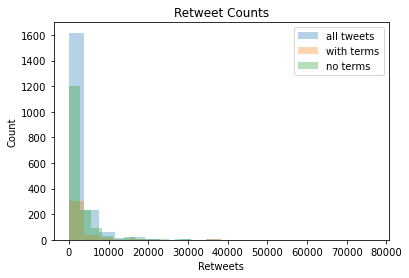

In [69]:
all_values = dog_df['retweets']
with_terms = dog_df[dog_df['dogtionary_terms'].notnull()]['retweets']
without_terms = dog_df[dog_df['dogtionary_terms'].isnull()]['retweets']

print('Mean of retweets is ' + str(all_values.mean()) + ' and standard deviation of ' + str(all_values.std()))
print('Mean of retweets with terms is ' + str(with_terms.mean()) + ' with z-score of ' + 
      str((with_terms.mean() - all_values.mean())/ ((all_values.std())/np.sqrt(len(with_terms)))))
print('Mean of retweets no terms is ' + str(without_terms.mean())+ ' with z-score of ' + 
      str((without_terms.mean() - all_values.mean())/ ((all_values.std())/np.sqrt(len(without_terms)))))

plt.hist(all_values, bins = 20, alpha = 0.33, label = 'all tweets')
plt.hist(with_terms, bins = 20, alpha = 0.33, label = 'with terms')
plt.hist(without_terms, bins = 20, alpha = 0.33, label = 'no terms')
plt.xlabel('Retweets')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('Retweet Counts')
plt.show()

It appears that the retweets of posts with dogtionary terms have a mean higher than the general population. It's statistically significant with an alpha level of 99%.

It is hard to read these retweet count histograms because of the different orders of magnitudes of the retweets. It's easier to see a comparison with a log of the retweet counts.

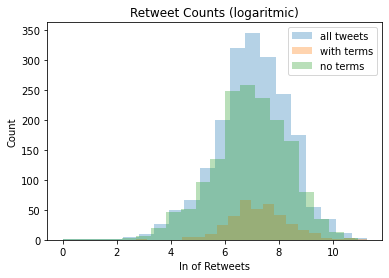

In [70]:
all_values = dog_df['log_retweets']
with_terms = dog_df[dog_df['dogtionary_terms'].notnull()]['log_retweets']
without_terms = dog_df[dog_df['dogtionary_terms'].isnull()]['log_retweets']

plt.hist(all_values, bins = 20, alpha = 0.33, label = 'all tweets')
plt.hist(with_terms, bins = 20, alpha = 0.33, label = 'with terms')
plt.hist(without_terms, bins = 20, alpha = 0.33, label = 'no terms')
plt.xlabel('ln of Retweets')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('Retweet Counts (logaritmic)')
plt.show()

Mean of favorites is 7059.620812182741 and standard deviation of 11531.44006626678
Mean of favorites with terms is 8402.383152173914 with z-score of 2.233775459592398
Mean of favorites no terms is 6751.171036204744 with z-score of -1.0706121528893497


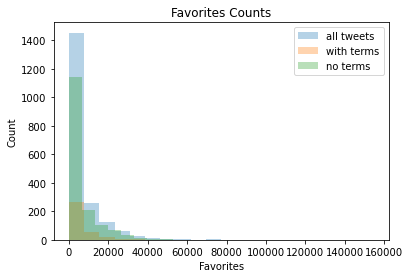

In [71]:
all_values = dog_df['favorites']
with_terms = dog_df[dog_df['dogtionary_terms'].notnull()]['favorites']
without_terms = dog_df[dog_df['dogtionary_terms'].isnull()]['favorites']

print('Mean of favorites is ' + str(all_values.mean()) + ' and standard deviation of ' + str(all_values.std()))
print('Mean of favorites with terms is ' + str(with_terms.mean()) + ' with z-score of ' + 
      str((with_terms.mean() - all_values.mean())/ ((all_values.std())/np.sqrt(len(with_terms)))))
print('Mean of favorites no terms is ' + str(without_terms.mean())+ ' with z-score of ' + 
      str((without_terms.mean() - all_values.mean())/ ((all_values.std())/np.sqrt(len(without_terms)))))

plt.hist(all_values, bins = 20, alpha = 0.33, label = 'all tweets')
plt.hist(with_terms, bins = 20, alpha = 0.33, label = 'with terms')
plt.hist(without_terms, bins = 20, alpha = 0.33, label = 'no terms')
plt.xlabel('Favorites')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('Favorites Counts')
plt.show()

Again, there appears that there is a statistically significant increase of favorites when a dogtionary term is used (with an alpha level of 99%).

Lets look at the logatrimic values look like here as well.

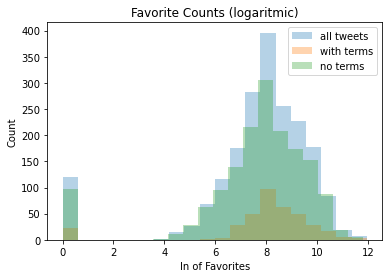

In [72]:
all_values = dog_df['log_favorites']
with_terms = dog_df[dog_df['dogtionary_terms'].notnull()]['log_favorites']
without_terms = dog_df[dog_df['dogtionary_terms'].isnull()]['log_favorites']

plt.hist(all_values, bins = 20, alpha = 0.33, label = 'all tweets')
plt.hist(with_terms, bins = 20, alpha = 0.33, label = 'with terms')
plt.hist(without_terms, bins = 20, alpha = 0.33, label = 'no terms')
plt.xlabel('ln of Favorites')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('Favorite Counts (logaritmic)')
plt.show()

### Dog Breed and Retweets/Favorites
Now let's look at dog breeds and how the effect the retweets and favorites.

In [73]:
breed_ided_df = dog_df[dog_df['most_likely_dog'] != 'no dog predicted']
breed_ided_df.shape

(1665, 24)

In [74]:
by_breed = breed_ided_df[['most_likely_dog', 'retweets', 'favorites']].groupby('most_likely_dog').agg(
    {'most_likely_dog':'count', 'retweets':['mean','min','median','max'], 'favorites':['mean','min','median','max']})
by_breed

most_likely_dog     retweets                \
                                         count         mean   min  median   
most_likely_dog                                                             
Afghan_hound                                 3  5005.333333  2254  3958.0   
Airedale                                    12  2188.083333   104  1269.0   
American_Staffordshire_terrier              16  5739.812500   184  2528.5   
Appenzeller                                  2  3656.000000   920  3656.0   
Australian_terrier                           2  2888.500000  1507  2888.5   
...                                        ...          ...   ...     ...   
toy_poodle                                  50  2348.380000    13  1297.5   
toy_terrier                                  3   950.666667   128   229.0   
vizsla                                      13  3687.307692   161  1998.0   
whippet                                     11  1314.000000   294   722.0   
wire-haired_fox_terrier                      2  2935.500000  1723  2935.5   

                                          favorites                        
                                  max          mean   min   median    max  
most_likely_dog                                                            
Afghan_hound                     8804  17231.666667  7910  12784.0  31001  
Airedale                        14760   3038.250000     0   2277.5  10170  
American_Staffordshire_terrier  36997   9701.687500     0   3144.5  56868  
Appenzeller                      6392  15025.500000  2039  15025.5  28012  
Australian_terrier               4270  11755.000000  4294  11755.0  19216  
...                               ...           ...   ...      ...    ...  
toy_poodle                      28950   5827.140000     0   3430.0  49318  
toy_terrier                      2495   2990.666667   273    551.0   8148  
vizsla                          16303   9500.000000     0   1499.0  44865  
whippet                          3438   6067.636364   625   2305.0  21119  
wire-haired_fox_terrier          4148   9516.500000  5780   9516.5  13253  

[113 rows x 9 columns]

In [75]:
by_breed.sort_values(by = ('retweets','mean'), ascending = False)

most_likely_dog      retweets                         \
                                  count          mean    min   median    max   
most_likely_dog                                                                
EntleBucher                           1  18345.000000  18345  18345.0  18345   
Irish_water_spaniel                   3  13010.333333   1737   7338.0  29956   
Border_terrier                        7   8353.142857     39   2621.0  43208   
Doberman                              9   8260.555556    546   2306.0  55897   
cairn                                 3   6571.000000    285    406.0  19022   
...                                 ...           ...    ...      ...    ...   
Scottish_deerhound                    4    566.250000    191    576.5    921   
Brabancon_griffon                     3    564.333333    517    584.0    592   
groenendael                           2    411.000000    222    411.0    600   
black-and-tan_coonhound               2    107.000000    104    107.0    110   
standard_schnauzer                    1     83.000000     83     83.0     83   

                            favorites                          
                                 mean    min   median     max  
most_likely_dog                                                
EntleBucher              30941.000000  30941  30941.0   30941  
Irish_water_spaniel      36301.333333   5188  29668.0   74048  
Border_terrier           24831.285714      0   3486.0  131685  
Doberman                 21848.222222   1564  10527.0  119305  
cairn                      769.000000      0    502.0    1805  
...                               ...    ...      ...     ...  
Scottish_deerhound        1696.250000    568   1906.0    2405  
Brabancon_griffon         1447.333333   1322   1399.0    1621  
groenendael               1103.500000    523   1103.5    1684  
black-and-tan_coonhound    147.000000      0    147.0     294  
standard_schnauzer         618.000000    618    618.0     618  

[113 rows x 9 columns]

In [76]:
# To better analyize, getting a csv of this.
by_breed.to_csv('breed.csv')

This looks like it would be a promising avenue to go down in further analysis. There are some breeds with only a few pictures, so we'd probably want to group similar breeds together to get a better picture of this. Also, it might be interesting to get more information on the pictures to see if anything else, like how a picture is framed has any effect.

### Ratings and Retweets/Favorites
Finally, I'd like to see if the rating has an effect on the retweets and favorites. I'm going to use the decimal rating I created to do the comparison and I'm going to drop the outliers.

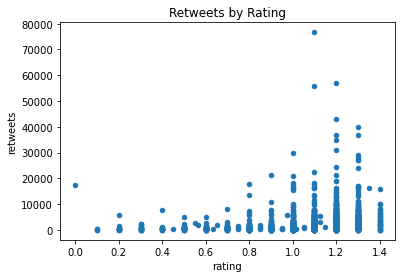

In [77]:
reduced_df = dog_df[dog_df['rating']<2]
reduced_df.plot.scatter('rating','retweets', title = 'Retweets by Rating')

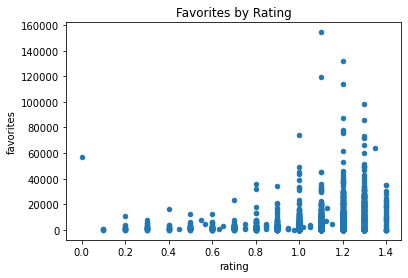

In [78]:
reduced_df.plot.scatter('rating','favorites',title = 'Favorites by Rating')

There appears to be some correlation between the rating and the number of retweets and favorites. Again, this bears looking into.